In [1]:
import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

import sys
!{sys.executable} -m pip install pandas-profiling

# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from math import ceil
import matplotlib.cm as cm
import joblib
import random
from collections import Counter

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, estimate_bandwidth

from sklearn.base import clone
from sklearn.metrics import pairwise_distances

from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split


# Data Understanding

CUSTID	------ customer ID number	
DAYSWUS ------ number of days as a customer
AGE	------ customer’s age or imputed age
EDUC	---	years of education (may be imputed)
INCOME	---	household income (may be imputed)
FREQ	----	number of purchases in past 18 mo.
RECENCY	-----	number of days since last purchase
MONETARY	-----	total sales to this person in 18 mo.
LTV	-----	Lifetime value of the customer
PERDEAL ----- purchases bought on discount
DRYRED ----- of wines that were dry red wines
SWEETRED ---  sweet or semi-dry reds
DRYWH	---- dry white wines
SWEETWH	---- sweet or semi-dry white wines
DESSERT	----- dessert wines (port, sherry, etc.)
EXOTIC	---- very unusual wines
WEBPURC ----- of purchases made on website
WEBVISIT --- average # visits to website per month

In [2]:
df = pd.read_excel(r'./../Data\WonderfulWinesoftheWorld.xlsx')
df

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
0,5325.0,653.000,55.0000,20.0000,78473.000,20.0000,18.0000,826.0000,445.0000,7.0000,67.0000,4.0000,26.0000,2.0000,1.0000,1.0000,36.0000,5.0000
1,3956.0,1041.000,75.0000,18.0000,105087.000,36.0000,33.0000,1852.0000,539.0000,2.0000,49.0000,0.0000,46.0000,1.0000,3.0000,0.0000,20.0000,4.0000
2,3681.0,666.000,18.0000,12.0000,27984.000,4.0000,56.0000,39.0000,-7.0000,88.0000,4.0000,29.0000,14.0000,32.0000,21.0000,48.0000,60.0000,8.0000
3,2829.0,1049.000,42.0000,16.0000,61748.000,2.0000,46.0000,37.0000,-6.0000,70.0000,86.0000,1.0000,11.0000,1.0000,1.0000,55.0000,59.0000,7.0000
4,8788.0,837.000,47.0000,16.0000,65789.000,2.0000,3.0000,36.0000,4.0000,35.0000,85.0000,0.0000,12.0000,2.0000,1.0000,28.0000,63.0000,6.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,4070.0,596.000,66.0000,15.0000,84714.000,18.0000,45.0000,720.0000,391.0000,5.0000,30.0000,12.0000,36.0000,10.0000,12.0000,13.0000,18.0000,2.0000
9997,7909.0,619.000,18.0000,12.0000,40466.000,3.0000,65.0000,47.0000,5.0000,23.0000,6.0000,24.0000,10.0000,38.0000,22.0000,41.0000,58.0000,5.0000
9998,4158.0,1107.000,33.0000,16.0000,53661.000,1.0000,368.0000,15.0000,2.0000,35.0000,18.0000,13.0000,45.0000,11.0000,13.0000,13.0000,60.0000,6.0000
9999,4914.0,979.000,55.0000,16.0000,94926.000,25.0000,28.0000,1148.0000,293.0000,7.0000,63.0000,10.0000,13.0000,11.0000,3.0000,4.0000,34.0000,5.0000


In [3]:
# Get to know the number of instances and Features, the DataTypes and if there are missing values in each Feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Custid       10000 non-null  float64
 1   Dayswus      10001 non-null  float64
 2   Age          10001 non-null  float64
 3   Edu          10001 non-null  float64
 4   Income       10001 non-null  float64
 5   Freq         10001 non-null  float64
 6   Recency      10001 non-null  float64
 7   Monetary     10001 non-null  float64
 8   LTV          10001 non-null  float64
 9   Perdeal      10001 non-null  float64
 10  Dryred       10001 non-null  float64
 11  Sweetred     10001 non-null  float64
 12  Drywh        10001 non-null  float64
 13  Sweetwh      10001 non-null  float64
 14  Dessert      10001 non-null  float64
 15  Exotic       10001 non-null  float64
 16  WebPurchase  10001 non-null  float64
 17  WebVisit     10001 non-null  float64
dtypes: float64(18)
memory usage: 1.4 MB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Custid,10000.0,6000.5000,2886.895680,1001.0,3500.75,6000.5,8500.25,11000.0
Dayswus,10001.0,898.1020,202.482664,550.0,724.00,894.0,1074.00,1250.0
Age,10001.0,47.9273,17.301856,18.0,33.00,48.0,63.00,78.0
Edu,10001.0,16.7391,1.876281,12.0,15.00,17.0,18.00,20.0
Income,10001.0,69904.3580,27610.852665,10000.0,47646.00,70009.0,92147.00,140628.0
Freq,10001.0,14.6281,11.968475,1.0,4.00,12.0,24.00,56.0
Recency,10001.0,62.4068,69.870762,0.0,26.00,52.0,78.00,549.0
Monetary,10001.0,622.5552,647.102966,6.0,63.00,383.0,1077.00,3052.0
LTV,10001.0,209.0712,291.971441,-178.0,-2.00,57.0,364.00,1791.0
Perdeal,10001.0,32.3972,27.895699,0.0,6.00,25.0,56.00,97.0


The last row represents the individual mean of all variables, so we will drop it

In [5]:
df.drop(axis=0,inplace = True, index=10000)

In [6]:
df

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
0,5325.0,653.0,55.0,20.0,78473.0,20.0,18.0,826.0,445.0,7.0,67.0,4.0,26.0,2.0,1.0,1.0,36.0,5.0
1,3956.0,1041.0,75.0,18.0,105087.0,36.0,33.0,1852.0,539.0,2.0,49.0,0.0,46.0,1.0,3.0,0.0,20.0,4.0
2,3681.0,666.0,18.0,12.0,27984.0,4.0,56.0,39.0,-7.0,88.0,4.0,29.0,14.0,32.0,21.0,48.0,60.0,8.0
3,2829.0,1049.0,42.0,16.0,61748.0,2.0,46.0,37.0,-6.0,70.0,86.0,1.0,11.0,1.0,1.0,55.0,59.0,7.0
4,8788.0,837.0,47.0,16.0,65789.0,2.0,3.0,36.0,4.0,35.0,85.0,0.0,12.0,2.0,1.0,28.0,63.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1383.0,1132.0,57.0,20.0,81033.0,19.0,59.0,776.0,187.0,22.0,78.0,0.0,20.0,1.0,1.0,11.0,27.0,4.0
9996,4070.0,596.0,66.0,15.0,84714.0,18.0,45.0,720.0,391.0,5.0,30.0,12.0,36.0,10.0,12.0,13.0,18.0,2.0
9997,7909.0,619.0,18.0,12.0,40466.0,3.0,65.0,47.0,5.0,23.0,6.0,24.0,10.0,38.0,22.0,41.0,58.0,5.0
9998,4158.0,1107.0,33.0,16.0,53661.0,1.0,368.0,15.0,2.0,35.0,18.0,13.0,45.0,11.0,13.0,13.0,60.0,6.0


### Data Types

In [7]:
discrete_variables = ['Custid','Dayswus','Age','Edu','Freq','Recency','Monetary','WebVisit']
df[discrete_variables] = df[discrete_variables].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Custid       10000 non-null  int64  
 1   Dayswus      10000 non-null  int64  
 2   Age          10000 non-null  int64  
 3   Edu          10000 non-null  int64  
 4   Income       10000 non-null  float64
 5   Freq         10000 non-null  int64  
 6   Recency      10000 non-null  int64  
 7   Monetary     10000 non-null  int64  
 8   LTV          10000 non-null  float64
 9   Perdeal      10000 non-null  float64
 10  Dryred       10000 non-null  float64
 11  Sweetred     10000 non-null  float64
 12  Drywh        10000 non-null  float64
 13  Sweetwh      10000 non-null  float64
 14  Dessert      10000 non-null  float64
 15  Exotic       10000 non-null  float64
 16  WebPurchase  10000 non-null  float64
 17  WebVisit     10000 non-null  int64  
dtypes: float64(10), int64(8)
memory usage: 1.4 MB


### Duplicates

In [8]:
# to see if there are more than one customer with the same ID
print('\033[1m' + "Number of duplicated CustID: " + '\033[0m' + str(df.duplicated(subset=['Custid']).sum()))  

Number of duplicated CustID: 0


In [9]:
# Checking if exist duplicated observations
print('\033[1m' + "Number of duplicated observations: " + '\033[0m' + str(df.duplicated().sum()))  

Number of duplicated observations: 0


### Missing Values

In [10]:
# Count the number of missing values for each Feature
df.isna().sum().to_frame().rename(columns={0: 'Count Missing Values'})

,Count Missing Values
Custid,0
Dayswus,0
Age,0
Edu,0
Income,0
Freq,0
Recency,0
Monetary,0
LTV,0
Perdeal,0


In [11]:
df[df['Custid'].isna()]

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit


In [12]:
df.sort_values(by='Custid', ascending=False)


,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
3401,11000,771,20,14,26385.0,4,24,46,-3.0,68.0,5.0,13.0,21.0,46.0,15.0,63.0,52.0,5
1584,10999,598,65,14,111018.0,28,4,1350,739.0,4.0,48.0,16.0,27.0,8.0,1.0,8.0,36.0,4
3017,10998,586,69,19,99628.0,30,98,1469,618.0,2.0,46.0,0.0,29.0,11.0,14.0,4.0,18.0,3
8942,10997,637,76,15,125962.0,33,75,1668,476.0,3.0,61.0,2.0,25.0,5.0,6.0,1.0,45.0,5
197,10996,967,28,17,54292.0,23,72,1011,436.0,7.0,41.0,11.0,36.0,1.0,11.0,42.0,31.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,1005,1062,59,18,91852.0,25,26,1138,355.0,5.0,59.0,5.0,28.0,4.0,4.0,19.0,34.0,6
6421,1004,893,59,19,93571.0,21,10,888,207.0,12.0,60.0,10.0,19.0,6.0,5.0,15.0,35.0,5
1027,1003,583,24,18,28344.0,4,69,44,-3.0,66.0,32.0,19.0,24.0,1.0,24.0,63.0,59.0,7
2305,1002,623,78,20,113023.0,31,6,1537,565.0,1.0,55.0,1.0,38.0,4.0,2.0,2.0,9.0,1


In [13]:
metric_features = df.columns.to_list()
metric_features.remove('Custid')

### Histograms for Numerical Variables

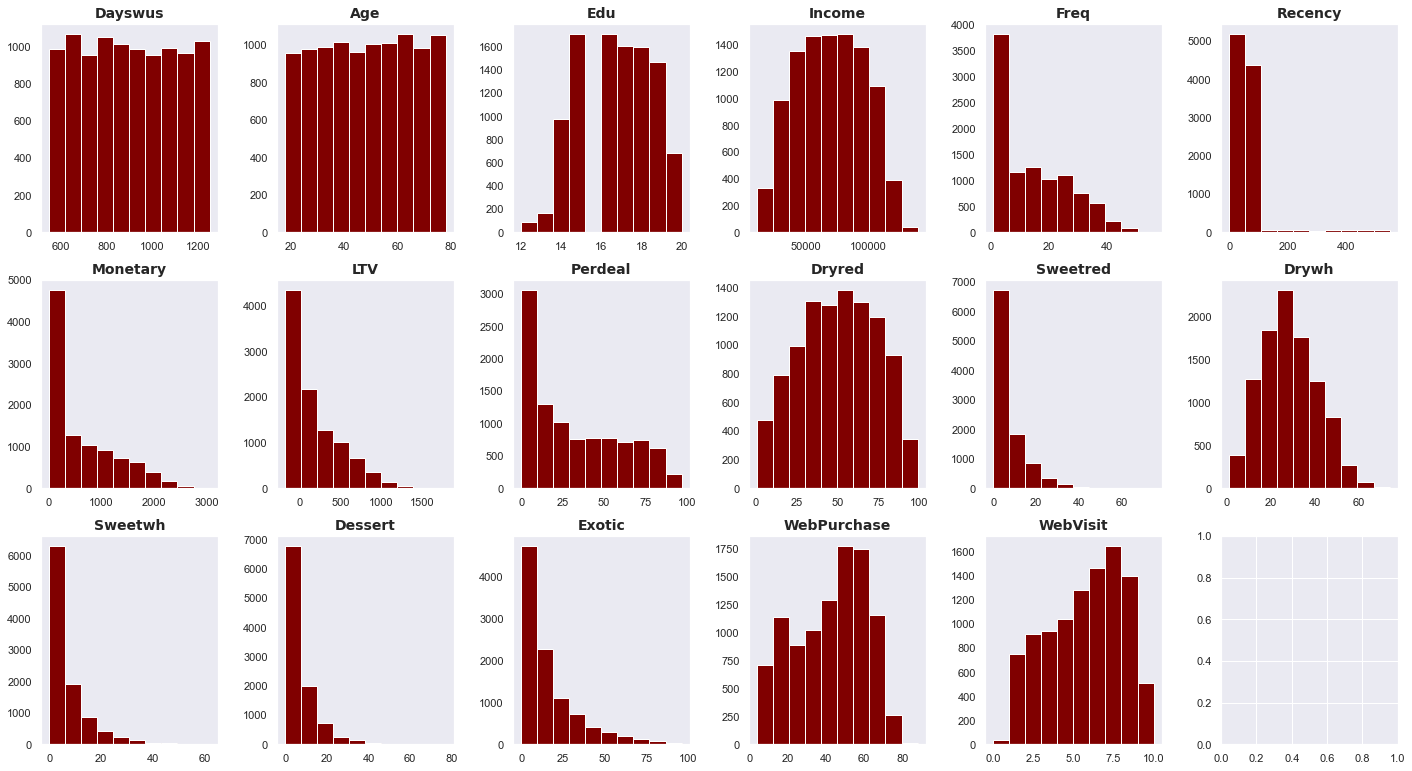

In [14]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 11))
fig.tight_layout(pad=2)

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df[feat], color="maroon")
    ax.grid(False)
    ax.set_title(feat, y=1,fontname="DejaVu Sans",fontsize=14,fontweight='bold')
    
# Layout
# Add a centered title to the figure:
#title = "Numeric Variables' Histograms"
#plt.suptitle(title)

plt.show()

In [15]:
df.loc[df['Edu']==16.0]

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
3,2829,1049,42,16,61748.0,2,46,37,-6.0,70.0,86.0,1.0,11.0,1.0,1.0,55.0,59.0,7
4,8788,837,47,16,65789.0,2,3,36,4.0,35.0,85.0,0.0,12.0,2.0,1.0,28.0,63.0,6
7,1815,1063,70,16,83942.0,29,20,1407,440.0,4.0,40.0,3.0,45.0,3.0,9.0,2.0,13.0,2
12,4625,1043,39,16,54468.0,2,63,37,-3.0,59.0,64.0,4.0,19.0,2.0,11.0,66.0,56.0,7
15,2799,820,36,16,57377.0,3,55,51,-11.0,71.0,70.0,4.0,20.0,1.0,5.0,74.0,41.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9970,8732,1003,33,16,51089.0,4,43,75,6.0,37.0,26.0,3.0,49.0,9.0,13.0,30.0,52.0,6
9990,10402,998,64,16,112899.0,32,56,1606,860.0,1.0,53.0,1.0,30.0,7.0,9.0,3.0,40.0,6
9993,8720,1097,44,16,58191.0,6,65,152,-19.0,70.0,52.0,4.0,34.0,5.0,5.0,2.0,46.0,7
9998,4158,1107,33,16,53661.0,1,368,15,2.0,35.0,18.0,13.0,45.0,11.0,13.0,13.0,60.0,6


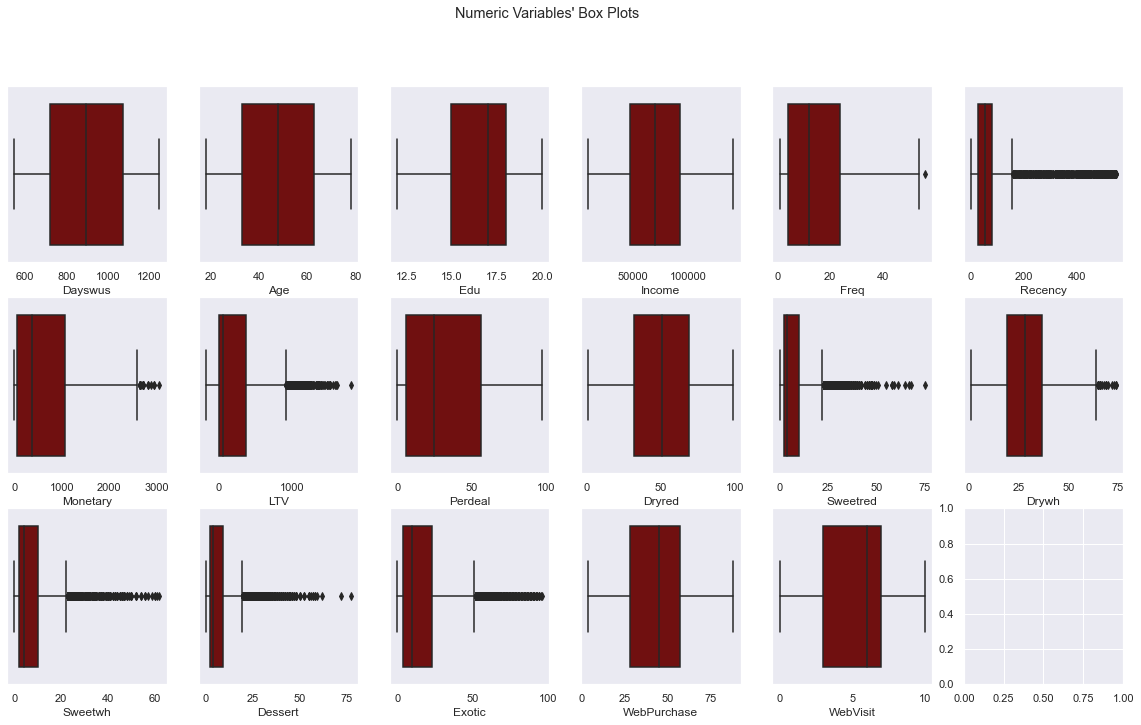

In [16]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x = df[feat], ax = ax, color="maroon").set_title('')
    ax.grid(False)
    #ax.set_title(feat, y=1,fontname="DejaVu Sans",fontsize=14,fontweight='bold')
    
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

## Correlation Check

<AxesSubplot:>

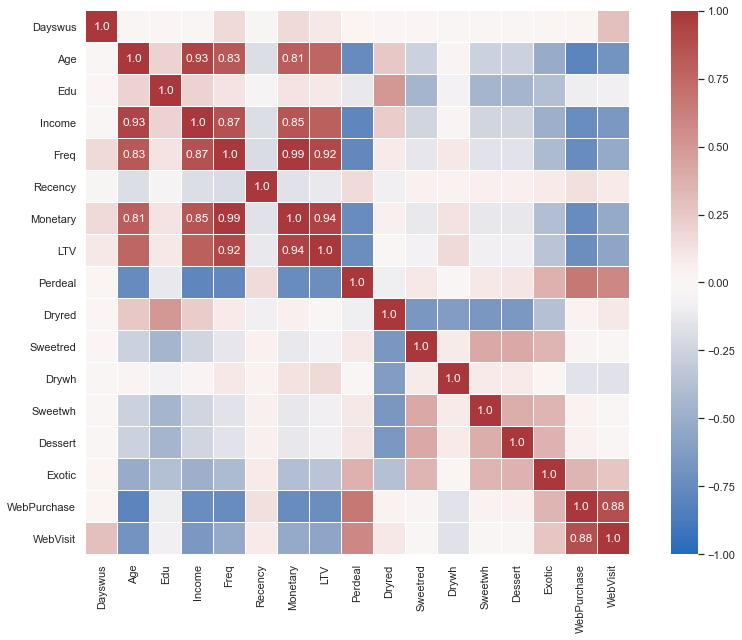

In [27]:
# Prepare figure
fig = plt.figure(figsize=(15, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.8
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data = corr, 
            annot = annot,
            cmap = sns.color_palette("vlag", as_cmap=True),#sns.cubehelix_palette(10, start=0, rot=0, dark=0, light=.95, reverse=True), 
            fmt='s',
            vmin=-1,
            vmax=1,
            center=0,
            square=True,
            linewidths=.5)

In [18]:
dropped_features = ['Income','Freq','Monetary']

clustering_features = metric_features.copy()

for feature in dropped_features:
    clustering_features.remove(feature)


In [19]:
print(clustering_features)

['Dayswus', 'Age', 'Edu', 'Recency', 'LTV', 'Perdeal', 'Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic', 'WebPurchase', 'WebVisit']


In [20]:
metric_features

['Dayswus',
 'Age',
 'Edu',
 'Income',
 'Freq',
 'Recency',
 'Monetary',
 'LTV',
 'Perdeal',
 'Dryred',
 'Sweetred',
 'Drywh',
 'Sweetwh',
 'Dessert',
 'Exotic',
 'WebPurchase',
 'WebVisit']

# Outlier removal

In [21]:
#test for outliers
df_tester = df.loc[df['Dessert'] > 50]
df_tester.sort_values(['Dessert'], ascending=False)

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
7019,9467,827,19,13,27911.0,5,38,47,-3.0,62.0,10.0,5.0,4.0,4.0,77.0,53.0,62.0,7
8335,5623,901,21,15,31059.0,1,172,17,2.0,24.0,5.0,3.0,11.0,8.0,72.0,30.0,65.0,8
6353,10474,1204,20,14,38147.0,5,96,120,17.0,16.0,5.0,16.0,11.0,6.0,62.0,52.0,63.0,8
7077,10791,1147,24,14,19353.0,5,71,62,-8.0,76.0,10.0,8.0,16.0,7.0,59.0,58.0,47.0,7
4348,10399,1234,18,12,21339.0,3,69,53,-11.0,89.0,3.0,6.0,5.0,29.0,58.0,89.0,57.0,8
6387,8365,558,20,14,28662.0,2,79,30,2.0,36.0,6.0,6.0,19.0,12.0,58.0,8.0,53.0,5
269,2736,701,18,12,29064.0,3,76,30,-4.0,77.0,8.0,4.0,18.0,13.0,57.0,82.0,49.0,4
5607,8748,936,25,16,41399.0,4,33,46,-8.0,83.0,15.0,4.0,19.0,5.0,57.0,53.0,62.0,6
957,2299,1016,19,13,32489.0,1,158,20,-3.0,83.0,10.0,21.0,12.0,1.0,56.0,27.0,69.0,9
1332,5594,1156,18,12,23775.0,5,54,72,5.0,38.0,4.0,9.0,23.0,8.0,55.0,83.0,74.0,8


In [22]:
filters1 = ((df['LTV'] <= 1700) #Salto de 1600 a 1791
            &
            # salto de 51.0 a 55.0
            (df['Sweetred'] <= 51)
            &
            # salto de 35 a 63
            (df['Dessert'] <= 62.0)
           )

df_clean = df[filters1]

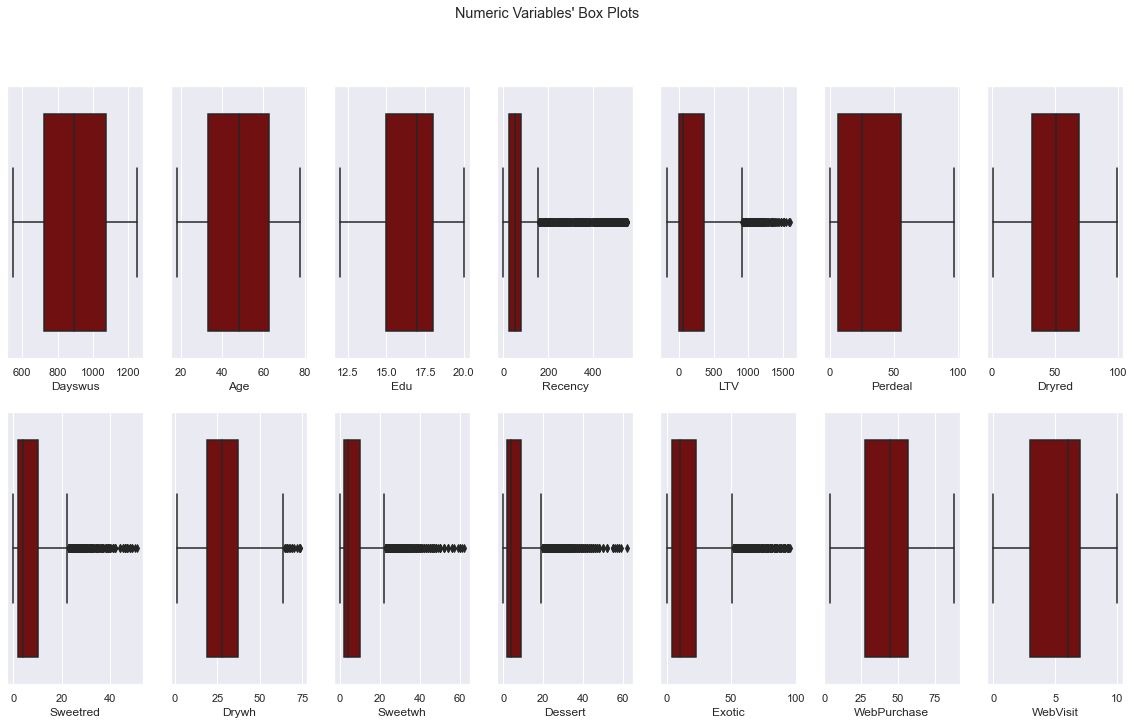

In [23]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(clustering_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), clustering_features): # Notice the zip() function and flatten() method
    sns.boxplot(x = df_clean[feat], ax = ax, color="maroon")
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [24]:
df_clean

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
0,5325,653,55,20,78473.0,20,18,826,445.0,7.0,67.0,4.0,26.0,2.0,1.0,1.0,36.0,5
1,3956,1041,75,18,105087.0,36,33,1852,539.0,2.0,49.0,0.0,46.0,1.0,3.0,0.0,20.0,4
2,3681,666,18,12,27984.0,4,56,39,-7.0,88.0,4.0,29.0,14.0,32.0,21.0,48.0,60.0,8
3,2829,1049,42,16,61748.0,2,46,37,-6.0,70.0,86.0,1.0,11.0,1.0,1.0,55.0,59.0,7
4,8788,837,47,16,65789.0,2,3,36,4.0,35.0,85.0,0.0,12.0,2.0,1.0,28.0,63.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1383,1132,57,20,81033.0,19,59,776,187.0,22.0,78.0,0.0,20.0,1.0,1.0,11.0,27.0,4
9996,4070,596,66,15,84714.0,18,45,720,391.0,5.0,30.0,12.0,36.0,10.0,12.0,13.0,18.0,2
9997,7909,619,18,12,40466.0,3,65,47,5.0,23.0,6.0,24.0,10.0,38.0,22.0,41.0,58.0,5
9998,4158,1107,33,16,53661.0,1,368,15,2.0,35.0,18.0,13.0,45.0,11.0,13.0,13.0,60.0,6


In [25]:
#Drop customer ID column 
df_clean.drop(axis=1,columns='Custid', inplace=True)